In [1]:
import numpy as np
import matplotlib.pyplot as plt

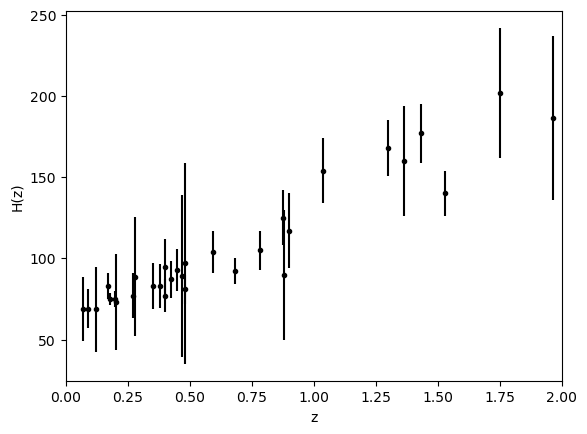

In [2]:
z = np.array([0.07,0.09,0.12,0.17,0.179,0.199,0.20,0.27,0.28,0.352,0.3802,0.4,0.4004,0.4247,0.4497,0.47,0.4783,0.48,0.593,0.68,0.781,0.875,0.88,0.90,1.037,1.3,1.363,1.43,1.53,1.75,1.965])
H = np.array([69,69,68.6,83,75,75,72.9,77,88.8,83,83,95,77,87.1,92.8,89,80.9,97,104,92,105,125,90,117,154,168,160,177,140,202,186.5])
Herr = np.array([19.6,12,26.2,8,4,5,29.6,14,36.6,14,13.5,17,10.2,11.2,12.9,50,9,62,13,8,12,17,40,23,20,17,33.6,18,14,40,50.4])

plt.errorbar(z, H, yerr=Herr, fmt=".k", capsize=0)
z0 = np.linspace(0, 2, 100)
#plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 2)
plt.xlabel("z")
plt.ylabel("H(z)");

Least-squares estimates:
m = 62.425 ± 6.065
b = 62.307 ± 3.146


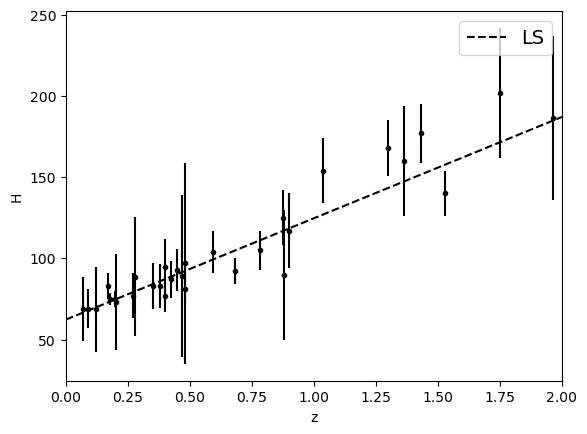

In [3]:
A = np.vander(z, 2)
C = np.diag(Herr * Herr)
ATA = np.dot(A.T, A / (Herr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, H / Herr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(z, H, yerr=Herr, fmt=".k", capsize=0)
#plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(z0, np.dot(np.vander(z0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("z")
plt.ylabel("H");

In [4]:
def H_calc(z,params):
    H0,omega_m0 = params
    return H0*np.sqrt(omega_m0*(1+z)**3 + (1-omega_m0))

In [5]:
from scipy.optimize import minimize

def chi_sqr(params):
    h0 = params[0]
    omega_m0 = params[1]
    return np.sum(((H_calc(z,params) - H)/Herr)**2)

result = minimize(chi_sqr,x0 = [68,0.32],method='BFGS')
print(result)
print("Optimal solution:", result.x)  # Optimized variables
print("Minimum value:", result.fun)   # Minimum value found

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 14.499985774271511
        x: [ 6.815e+01  3.196e-01]
      nit: 8
      jac: [-1.192e-07  7.629e-06]
 hess_inv: [[ 4.636e+00 -7.752e-02]
            [-7.752e-02  1.741e-03]]
     nfev: 30
     njev: 10
Optimal solution: [68.1499179   0.31955537]
Minimum value: 14.499985774271511


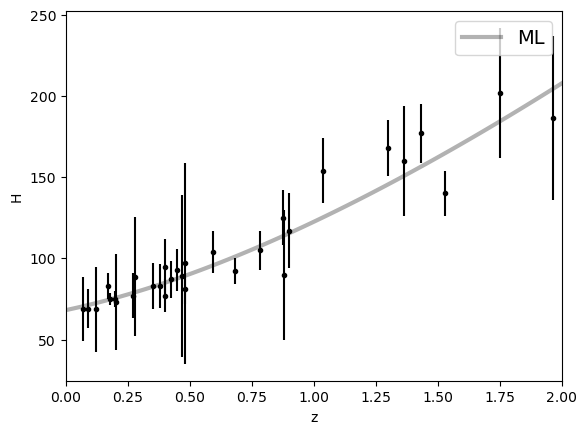

H0 =  68.14991789590066
Omega_m0 =  0.31955536934463985


In [6]:
plt.errorbar(z, H, yerr=Herr, fmt=".k", capsize=0)
plt.plot(z0, H_calc(z0,[result.x[0],result.x[1]]), "k", alpha=0.3, lw=3, label="ML")
#plt.plot(z0, np.dot(np.vander(z0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("z")
plt.ylabel("H")
plt.show()
print("H0 = ",result.x[0])
print("Omega_m0 = ",result.x[1])

In [7]:
def log_prior(theta):
    H0,omega_m0 = theta
    if 0.1<omega_m0<0.7 and 50<H0<85:
        return 0.0
    return -np.inf

In [8]:
def log_probability(theta, z, H, Herr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - chi_sqr(theta)/2

In [42]:
pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
import emcee

pos = result.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z, H, Herr)
)
sampler.run_mcmc(pos, 20000, progress=True);

100%|███████████████████████████████████| 20000/20000 [00:11<00:00, 1681.58it/s]


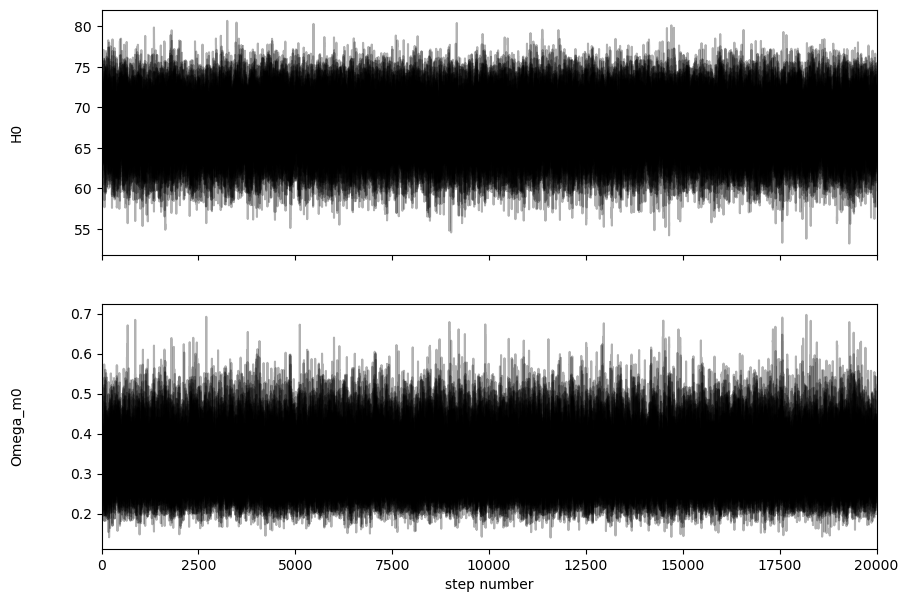

In [10]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0","Omega_m0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[31.10767398 31.94836939]


In [12]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(42432, 2)


In [28]:
pip install corner

Note: you may need to restart the kernel to use updated packages.


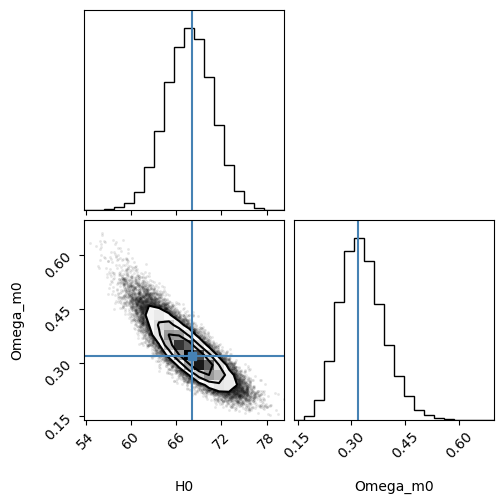

In [13]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[result.x[0], result.x[1]]
);

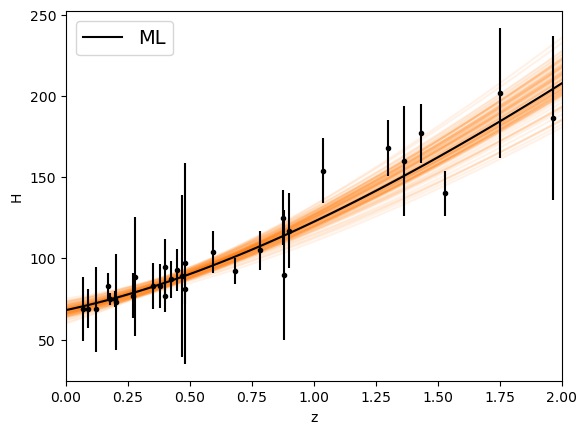

In [14]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    #print(sample)
    plt.plot(z0, H_calc(z0,[sample[0],sample[1]]), "C1", alpha=0.1)
plt.errorbar(z, H, yerr=Herr, fmt=".k", capsize=0)
plt.plot(z0, H_calc(z0,[result.x[0],result.x[1]]), "k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("z")
plt.ylabel("H");

In [15]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Now using BAO data

In [16]:
from scipy import integrate

c = 2.99792458e+5 #km/s
rs_fid = 147.78 #Mpc

def Hinv(z,params):
    H0,omega_m0 = params
    return 1/H_calc(z,params)

def Dm(z,params):
    return c*integrate.quad(Hinv,0,z,args=(params))[0]

In [17]:
def Dv(z,params):
    return np.cbrt((c*z*np.power(Dm(z,params),2))/H_calc(z,params))
def Dh(z,params):
    return c*Hinv(z,params)
def Da(z,params):
    return Dm(z,params)/(1+z)

In [18]:
def rs(z,params):
    H0,omega_m0 = params
    omega_v0 = 0.0014
    h = H0/100
    omega_b = 0.02225/(h**2)
    num = np.exp(-72.3*(omega_v0*h**2+0.0006)**2)
    den = ((omega_b*h**2)**0.12807)*((omega_m0-omega_v0)*h**2)**0.25351
    return 55.154*num/den

In [19]:
import pandas as pd
r = pd.read_csv("/Users/User8/Downloads/BAO_data.csv")
z_values = r["z"]
A_obs = r["Values"]
A_err = r["sigma"]



print(r)

        z     Values    sigma
0   0.380  1512.3900   22.000
1   0.380    81.2087   27.000
2   0.510  1975.2200   32.000
3   0.510    90.9029    1.900
4   0.610  2306.6800    1.900
5   0.610    98.9647    2.100
6   0.122   539.0000    0.015
7   0.810    10.7500   25.000
8   1.520  3843.0000  170.000
9   2.340     8.8600    0.350
10  2.340    37.4100    0.300


In [20]:
C = np.array([
    [624.707, 23.729, 325.332, 8.34963, 157.386, 3.57778, 0, 0, 0, 0, 0],
    [23.729, 5.60873, 11.6429, 2.33996, 6.39263, 0.968056, 0, 0, 0, 0, 0],
    [325.332, 11.6429, 905.777, 29.3392, 515.271, 14.1013, 0, 0, 0, 0, 0],
    [8.34963, 2.33996, 29.3392, 5.42327, 16.1422, 2.85334, 0, 0, 0, 0, 0],
    [157.386, 6.39263, 515.271, 16.1422, 1375.12, 40.4327, 0, 0, 0, 0, 0],
    [3.57778, 0.968056, 14.1013, 2.85334, 40.4327, 6.25936, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 289, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0.1849, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 21609, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0841, -0.183396],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -0.183396, 3.4596]
])
Cinv = np.linalg.inv(C)
print(Cinv)


[[ 2.41657574e-03 -1.08425129e-02 -9.77915124e-04  6.54318580e-03
   9.58923119e-05 -1.10347720e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.08425129e-02  2.67032468e-01  4.97942781e-03 -1.33483795e-01
  -8.96901216e-04  2.03235036e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.77915124e-04  4.97942781e-03  2.13608860e-03 -1.29721787e-02
  -7.22812335e-04  5.55904513e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.54318580e-03 -1.33483795e-01 -1.29721787e-02  3.68207044e-01
   4.92437098e-03 -1.53528669e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.58923119e-05 -8.96901216e-04 -7.22812335e-04  4.92437098e-03
   1.17162779e-03 -8.10070309e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.10347720e-03  2.03235036e-02  5.55904513e-03 -1.53528669e-01
  -8.10070309e-03  

In [21]:
def ATheo(z,params):
    #print(z)
    A_theo = np.zeros(11)

    
    dm_ind = [0,2,4]
    h_ind = [3,1,5]
    dv_ind = [6,8]
    da_ind = [7]
    dhrs_ind = [9]
    dmrs_ind = [10]
    
    
    for i in dm_ind:
        A_theo[i] = Dm(z[i],params)*rs_fid/rs(z[i],params)
    for i in h_ind:   
        A_theo[i] = H_calc(z[i],params)*rs_fid/rs(z[i],params)
    for i in dv_ind:
        if i==6:
            A_theo[i] = Dv(z[i],params)*147.5/rs(z[i],params)
        else:
            A_theo[i] = Dv(z[i],params)*rs_fid/rs(z[i],params)
    A_theo[7] = Da(z[7],params)/rs(z[7],params)
    A_theo[9] = Dh(z[9],params) / rs(z[9],params)
    A_theo[10] = Dm(z[10],params)/rs(z[10],params)                         
    
    return A_theo

ATheo(z_values,[67.691,0.328])

array([1546.60890926,   85.26058739, 2000.92385525,   92.39024775,
       2326.25355153,   98.3419088 ,  525.97732931,   10.91323536,
       3866.93649639,    8.48784952,   39.12623796])

In [22]:
def chi_sqr2(params):
    A = ATheo(z_values,params) - A_obs
    chi_sq = np.matmul(A.T,np.matmul(Cinv,A))
    
    return chi_sq

print(chi_sqr2([68,0.31]))

5.996524721425291


In [23]:
def Chi_sqr(params):
    return (chi_sqr(params)+chi_sqr2(params))


result = minimize(Chi_sqr,x0 = [70,0.024],bounds=[(0,np.inf),(0,1)])
print(result)
print(result.x)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 20.44190927370002
        x: [ 6.804e+01  3.147e-01]
      nit: 19
      jac: [-4.263e-06  0.000e+00]
     nfev: 60
     njev: 20
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
[68.03977869  0.3147174 ]


In [24]:
def log_probability2(theta, z, H, Herr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - (Chi_sqr(theta))/2

In [25]:
import emcee

pos = result.x + 1e-4 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape

z_tot = np.concatenate((z,z_values))
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability2, args=(z_tot, H, Herr)
)
sampler.run_mcmc(pos, 5000, progress=True);

  2%|▉                                       | 124/5000 [00:11<07:16, 11.16it/s]Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/m3/7t2xw3cx0x7ck93f0ctpcmmw0000gn/T/ipykernel_30891/3884691899.py", line 5, in log_probability2
    return lp - (Chi_sqr(theta))/2
                 ^^^^^^^^^^^^^^
  File "/var/folders/m3/7t2xw3cx0x7ck93f0ctpcmmw0000gn/T/ipykernel_30891/663653529.py", line 2, in Chi_sqr
    return (chi_sqr(params)+chi_sqr2(params))
                            ^^^^^^^^^^^^^^^^
  File "/var/folders/m3/7t2xw3cx0x7ck93f0ctpcmmw0000gn/T/ipykernel_30891/3631572512.py", line 2, in chi_sqr2
    A = ATheo(z_values,params) - A_obs
        ^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/m3/7t2xw3cx0x7ck93f0ctpcmmw0000gn/T/ipykernel_30891/2012191789.py", line 25, in ATheo
    A_theo[10] = D

emcee: Exception while calling your likelihood function:
  params: [69.28102943  0.29274876]
  args: (array([0.07  , 0.09  , 0.12  , 0.17  , 0.179 , 0.199 , 0.2   , 0.27  ,
       0.28  , 0.352 , 0.3802, 0.4   , 0.4004, 0.4247, 0.4497, 0.47  ,
       0.4783, 0.48  , 0.593 , 0.68  , 0.781 , 0.875 , 0.88  , 0.9   ,
       1.037 , 1.3   , 1.363 , 1.43  , 1.53  , 1.75  , 1.965 , 0.38  ,
       0.38  , 0.51  , 0.51  , 0.61  , 0.61  , 0.122 , 0.81  , 1.52  ,
       2.34  , 2.34  ]), array([ 69. ,  69. ,  68.6,  83. ,  75. ,  75. ,  72.9,  77. ,  88.8,
        83. ,  83. ,  95. ,  77. ,  87.1,  92.8,  89. ,  80.9,  97. ,
       104. ,  92. , 105. , 125. ,  90. , 117. , 154. , 168. , 160. ,
       177. , 140. , 202. , 186.5]), array([19.6, 12. , 26.2,  8. ,  4. ,  5. , 29.6, 14. , 36.6, 14. , 13.5,
       17. , 10.2, 11.2, 12.9, 50. ,  9. , 62. , 13. ,  8. , 12. , 17. ,
       40. , 23. , 20. , 17. , 33.6, 18. , 14. , 40. , 50.4]))
  kwargs: {}
  exception:


KeyboardInterrupt: 

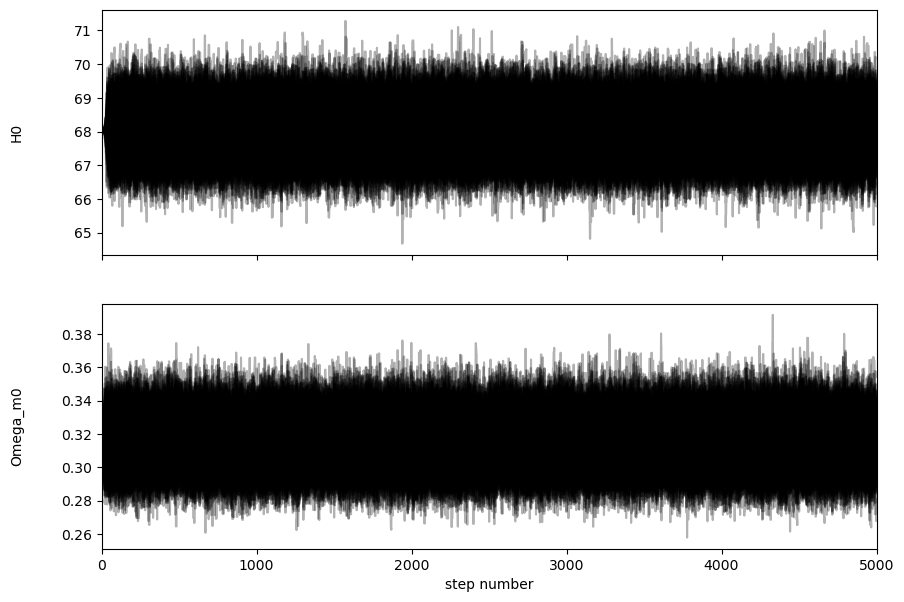

In [48]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0","Omega_m0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [49]:
tau = sampler.get_autocorr_time()
print(tau)

[30.68412092 29.19905875]


In [50]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(65200, 2)


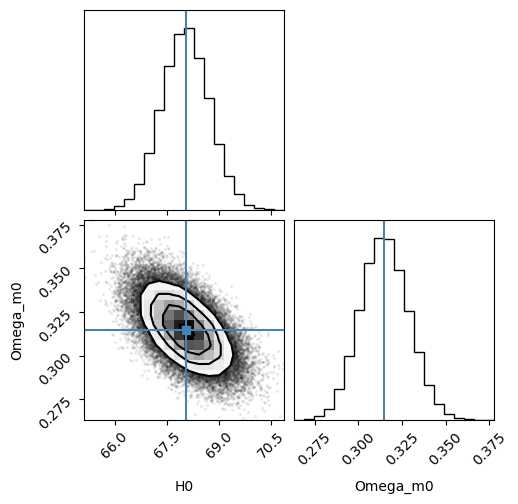

In [51]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[result.x[0], result.x[1]]
);

In [52]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Using QSO Data

In [26]:
import pandas as pd
r = pd.read_csv("/Users/User8/Downloads/QSO - Sheet1.csv")
z_values2 = r["Z"]
t_obs = r["0"]
t_err = r["σg"]



print(r)

           Source       Z      0     σg       S       α Type
0      P 2351-006  0.4620  2.743  0.027   2.490    -0.1    Q
1          3C 279  0.5362  1.454  0.052  11.800     0.1    Q
2      P 0252-549  0.5390  1.049  0.077   1.940     0.1    Q
3       P 1136-13  0.5580  1.974  0.048   3.400    -0.3    Q
4       P 0403-13  0.5740  2.399  0.077   4.000     0.1    Q
..            ...     ...    ...    ...     ...     ...  ...
115    P 1032-199  2.1980  1.434  0.036   1.082     0.1  NaN
116    P 2314-409  2.4480  1.676  0.045   0.525  -0.3 Q  NaN
117  GC 1337 + 63  2.5584  1.598  0.323   0.600    -0.2  NaN
118    P 0329-255  2.6850  1.506  0.101   0.417  -0.1 Q  NaN
119  P 0136 + 176  2.7300  1.252  0.132   0.520    0 PQ  NaN

[120 rows x 7 columns]


In [27]:
lm = 11.03

def t_theo(z,params):
    results = []
    for value in z:
        # Perform operations using 'value' from the Series
        result = lm / Da(value, params)
        results.append(result)
    return results

In [28]:
def chi_sqr3(params):
    return np.sum(((t_theo(z_values2,params) - t_obs)/(0.1*t_obs + t_err))**2)
print(chi_sqr3([70,0.024]))

3912.090920006833


In [40]:
result = minimize(chi_sqr3,x0 = [70,0.024],bounds=[(0,np.inf),(0,1)])
print(result)
print(result.x)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 352.0461744896958
        x: [ 1.417e+04  3.153e-01]
      nit: 16
      jac: [-5.684e-06  2.561e-02]
     nfev: 114
     njev: 38
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
[1.41683774e+04 3.15348101e-01]


In [31]:
def log_probability2(theta, z, H, Herr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - (Chi_sqr(theta))/2

In [35]:
import emcee

pos = result.x + 1e-4 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape

z_tot = np.concatenate((z,z_values))
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability2, args=(z_tot, H, Herr)
)
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████████████████████████████████| 2000/2000 [00:02<00:00, 996.89it/s]


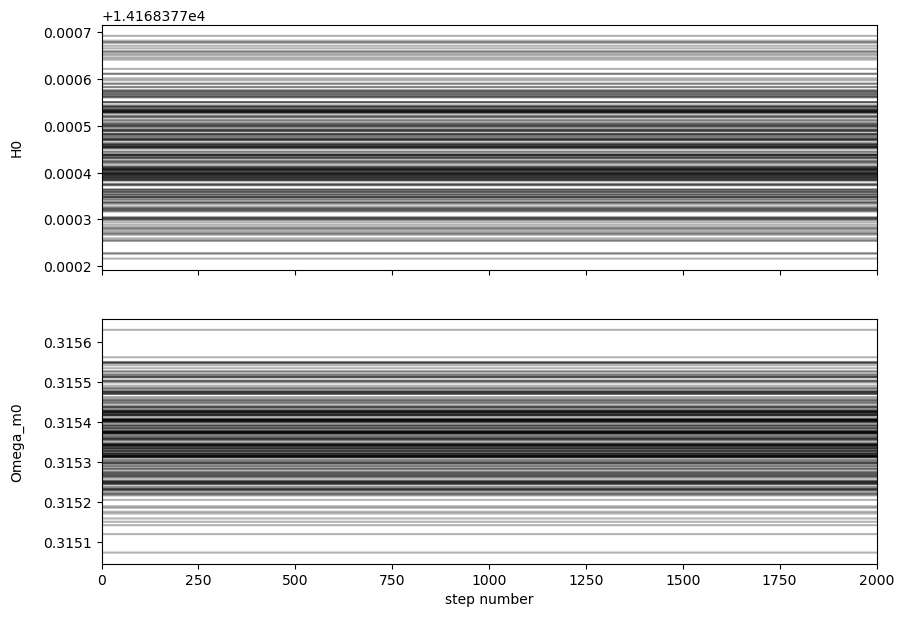

In [36]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0","Omega_m0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [34]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan]


/Applications/anaconda3/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


In [39]:
def Chi_sqr(params):
    return (chi_sqr(params)+chi_sqr2(params)+chi_sqr3(params))


result = minimize(Chi_sqr,x0 = [70,0.024],bounds=[(0,np.inf),(0,1)])
print(result)
print(result.x)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3924.7978226692685
        x: [ 6.810e+01  3.154e-01]
      nit: 18
      jac: [ 1.364e-04 -6.821e-04]
     nfev: 57
     njev: 19
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
[68.09783246  0.31542274]


In [68]:
def log_probability2(theta, z, H, Herr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - (Chi_sqr(theta))/2

In [69]:
import emcee

pos = result.x + 1e-4 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape

z_tot = np.concatenate((z,z_values))
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability2, args=(z_tot, H, Herr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████| 5000/5000 [3:10:27<00:00,  2.29s/it]


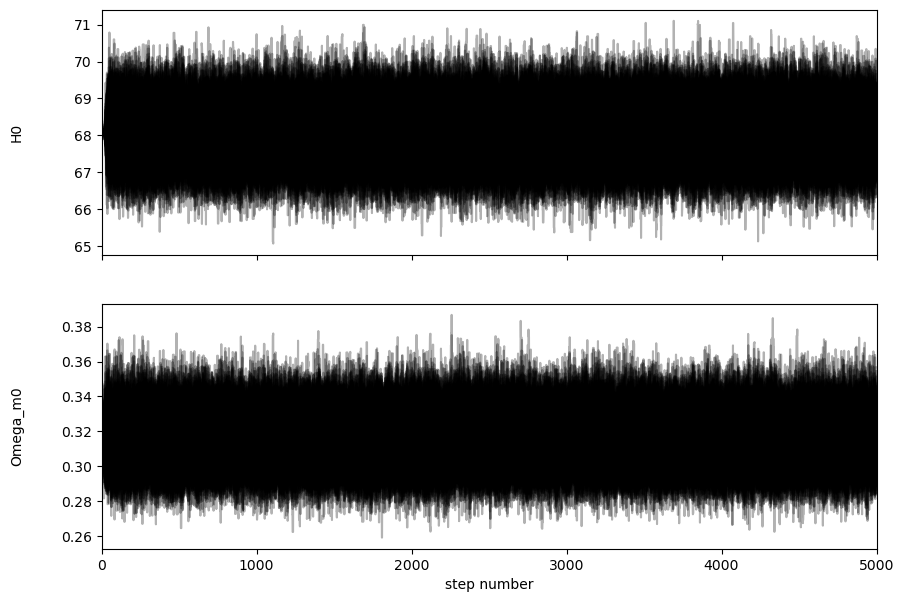

In [70]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0","Omega_m0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [71]:
tau = sampler.get_autocorr_time()
print(tau)

[29.48444474 29.79428999]


In [72]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(65200, 2)


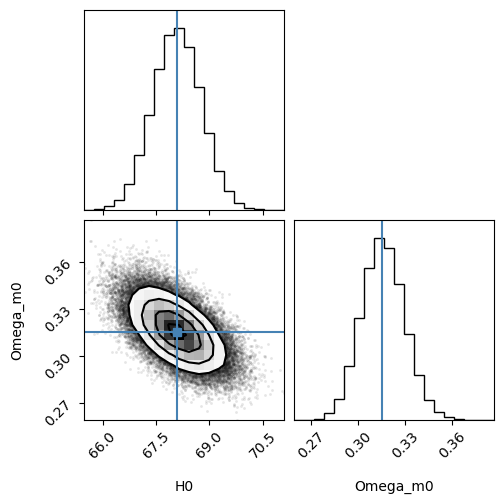

In [73]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[result.x[0], result.x[1]]
);

In [74]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>